### Hierarchical Marketing Mix model
Imagine that you work in a marketing department and want to investigate if your advertising investments paid off or not. If so, To what extent did  all advertising contribute to the sales or conversion/user acquisition? If our model can do this, we can also use it to compute ROIs and optimize spending, which is what companies ultimately want. With this goal in mind
we present a concrete example of estimating the media effects via bayesian methods, following the strategy outlined in Google’s paper. [“Bayesian methods for media mix modeling with carryover and shape effects.” (2017)](https://research.google/pubs/pub46001/)

The Bayesian technique works particularly effectively with homogenous data, which means that the impacts of your advertising expenditures are comparable across your dataset. But what if we have a diverse dataset, such as expenditure across multiple countries? There are two obvious approaches to deal with it:

Ignore the fact that there are several countries in the dataset and build a 
1. single big model.
2. Build one model per country.

Unfortunately, both strategies have drawbacks. To cut a long tale short, ignoring the country results in an overly coarse model that is likely to be underfitting. On the other side, if you construct a model for each country, you may wind up with too many models to manage. Worse, if some countries don't have a lot of data points, your model may overfit.

Creating a hybrid model that is somewhere between these two approaches is usually more efficient: **Hierarchical Bayesian modeling**!

In [1]:
import warnings
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import pymc as pm
import pytensor.tensor as pt
warnings.filterwarnings("ignore")

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

Lets load a synthetic dataset  which is taken from this blogpost ["Introduction to Marketing Mix Modeling"](https://towardsdatascience.com/introduction-to-marketing-mix-modeling-in-python-d0dd81f4e794), which is acceptable for training purposes.

In [2]:
data_df = pd.read_csv('Input_data/Mediaspenddata.csv', parse_dates=["Date"])

data_df.info()

data_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Country  320 non-null    object        
 1   Date     320 non-null    datetime64[ns]
 2   TV       320 non-null    float64       
 3   Radio    320 non-null    float64       
 4   Banners  320 non-null    float64       
 5   Sales    320 non-null    float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 15.1+ KB


Country       Date            TV        Radio      Banners  \
0        Germany 2018-01-07  13528.104692     0.000000     0.000000   
1        Germany 2018-01-14      0.000000  5349.654457  2218.927675   
2        Germany 2018-01-21      0.000000  4235.856076  2046.964305   
3        Germany 2018-01-28      0.000000  3562.208526     0.000000   
4        Germany 2018-02-04      0.000000     0.000000  2187.289145   
..           ...        ...           ...          ...          ...   
315  Switzerland 2018-04-22      0.000000  6199.736176  1995.974179   
316  Switzerland 2018-04-29      0.000000  5456.153036  2155.004653   
317  Switzerland 2018-05-06      0.000000  4642.420968     0.000000   
318  Switzerland 2018-05-13  10076.254768  5041.082226  1838.256494   
319  Switzerland 2018-05-20      0.000000  5593.465920     0.000000   

           Sales  
0    5279.797721  
1    8745.187503  
2    7522.658746  
3    4346.954005  
4    5297.070969  
..           ...  
315  8260.525106  
316  8067.092448  
317  4039.670872  
318  9721.207803  
319  6122.552884  

[320 rows x 6 columns]

In [4]:
data_df.set_index(['Date', 'Country'])

TV        Radio      Banners        Sales
Date       Country                                                         
2018-01-07 Germany      13528.104692     0.000000     0.000000  5279.797721
2018-01-14 Germany          0.000000  5349.654457  2218.927675  8745.187503
2018-01-21 Germany          0.000000  4235.856076  2046.964305  7522.658746
2018-01-28 Germany          0.000000  3562.208526     0.000000  4346.954005
2018-02-04 Germany          0.000000     0.000000  2187.289145  5297.070969
...                              ...          ...          ...          ...
2018-04-22 Switzerland      0.000000  6199.736176  1995.974179  8260.525106
2018-04-29 Switzerland      0.000000  5456.153036  2155.004653  8067.092448
2018-05-06 Switzerland      0.000000  4642.420968     0.000000  4039.670872
2018-05-13 Switzerland  10076.254768  5041.082226  1838.256494  9721.207803
2018-05-20 Switzerland      0.000000  5593.465920     0.000000  6122.552884

[320 rows x 4 columns]

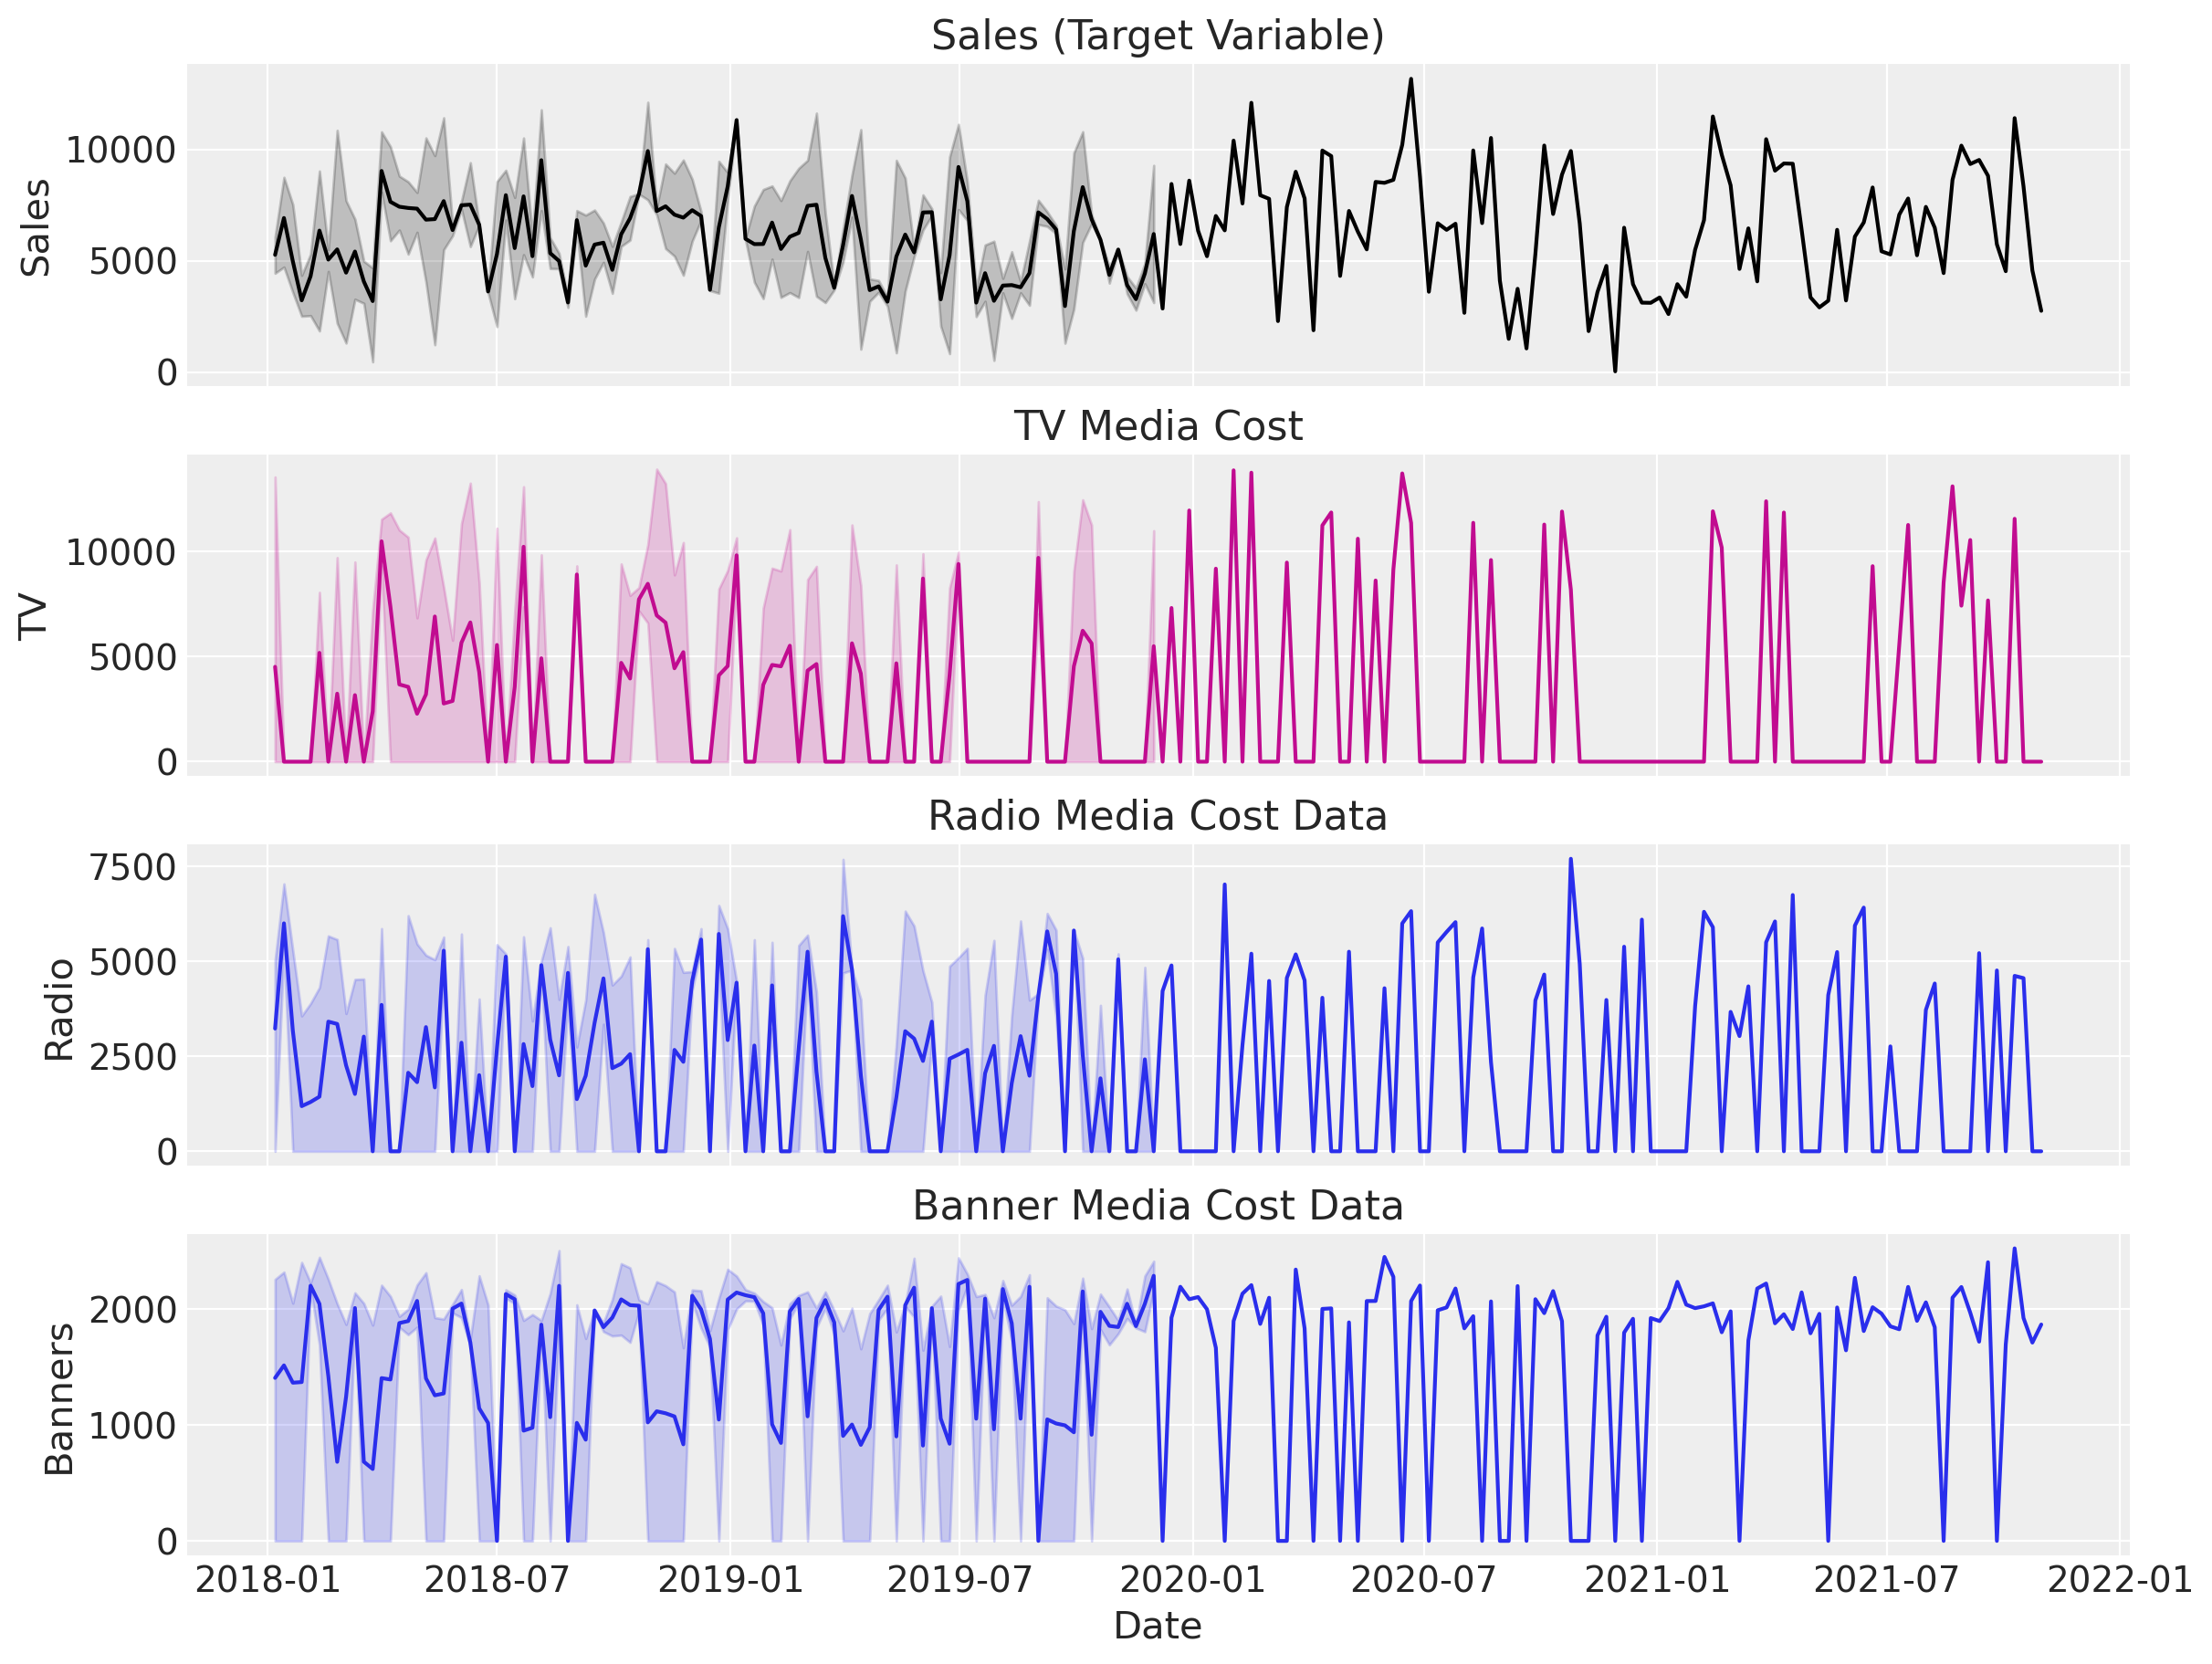

In [3]:
fig, ax = plt.subplots(
    nrows=4,
    ncols=1,
    figsize=(12, 9),
    sharex=True,
    sharey=False,
    layout="constrained"
)
sns.lineplot(x="Date", y="Sales", color="black", data=data_df, ax=ax[0])
ax[0].set(title="Sales (Target Variable)")
sns.lineplot(x="Date", y="TV", color="C3", data=data_df, ax=ax[1])
ax[1].set(title="TV Media Cost")
sns.lineplot(x="Date", y="Radio", data=data_df, ax=ax[2])
ax[2].set(title="Radio Media Cost Data");
sns.lineplot(x="Date", y="Banners", data=data_df, ax=ax[3])
ax[3].set(title="Banner Media Cost Data");

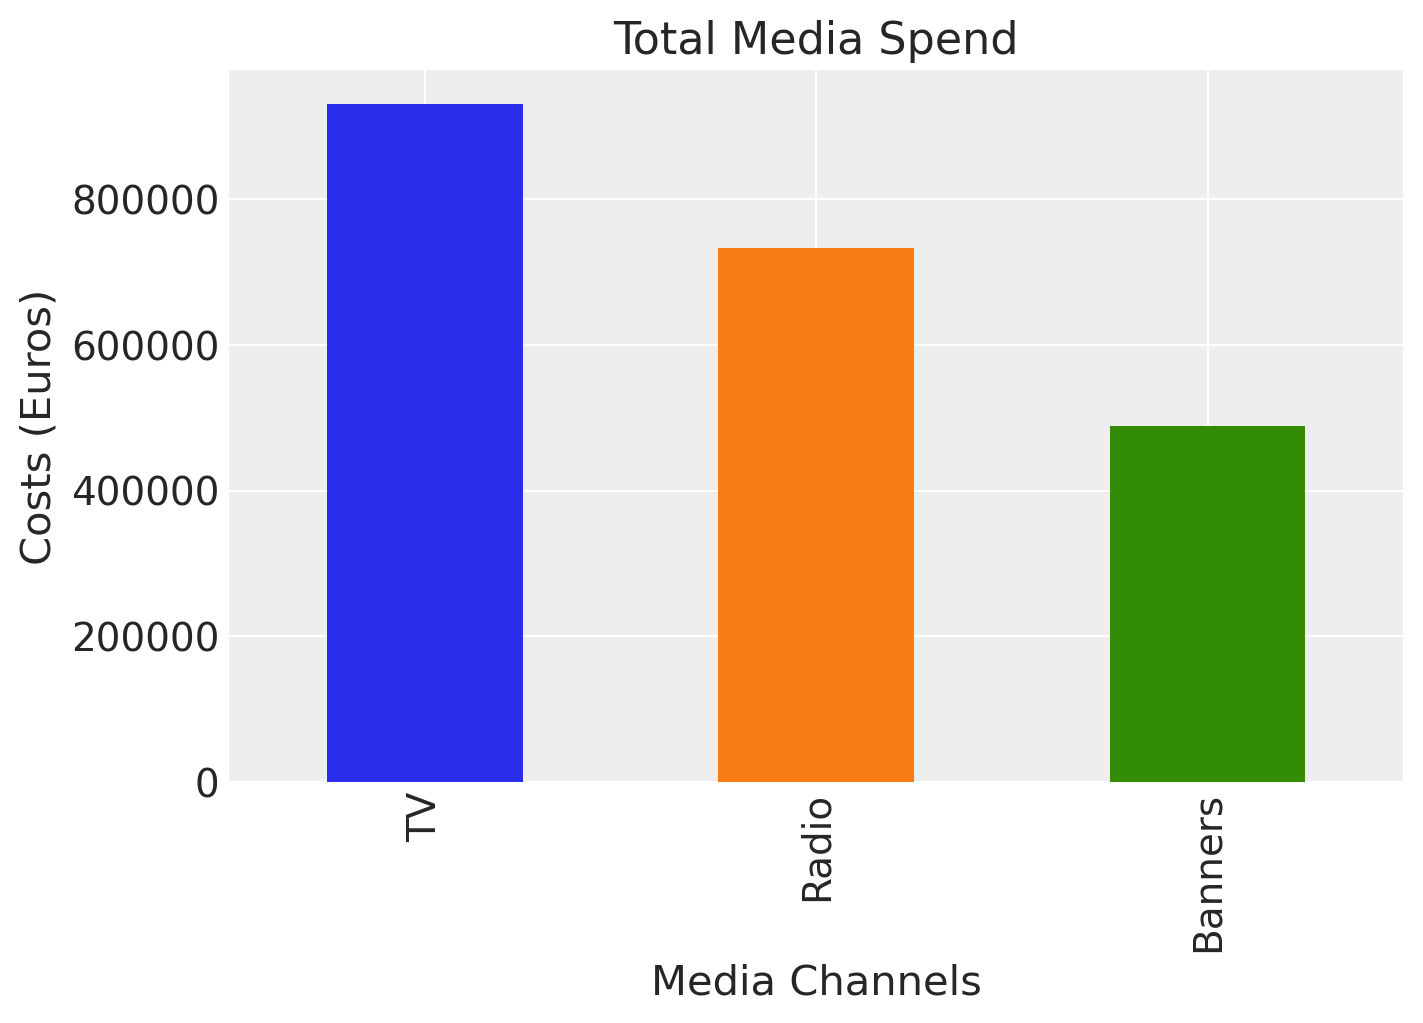

In [4]:
fig, ax = plt.subplots(figsize=(7, 5))
data_df[['TV','Radio', 'Banners']].sum().plot(kind="bar", color=["C0", "C1", 'C2'], ax=ax)
ax.set(title="Total Media Spend", xlabel="Media Channels", ylabel="Costs (Euros)");

In [5]:
X = data_df.drop(columns=["Sales", "Date"])
y = data_df["Sales"]

#### Feature Engineering 

#### Advertising Adstock

1. It stands to reason that your sales will increase with increased advertising expenditures. But as we spend more, the increase becomes less pronounced. For instance, raising TV spending from 0 to 100,000 improves sales significantly; but, increasing TV spending from 100,000,000 to 100,100,000 no longer has the same effect. This phenomenon is referred to as the effect of diminishing returns or saturation effect.

2. Many times, if you invest money in promoting during week T, consumers will purchase your goods a few (let's say x) weeks later. This is because the product may be pricey and consumers want to thoroughly consider their options or evaluate it against comparable offerings from other businesses. For whatever reason, the advertising you ran in week T contributed to the sale in week T + x, therefore that should count for something as well. The term "carryover" or "lag effect" describes this.

In [6]:
def geometric_adstock(x, alpha: float = 0.0, l_max: int = 12):
    """Geometric adstock transformation."""
    cycles = [
        pt.concatenate(
            [pt.zeros(i), x[: x.shape[0] - i]]
        )
        for i in range(l_max)
    ]
    x_cycle = pt.stack(cycles)
    w = pt.as_tensor_variable([pt.power(alpha, i) for i in range(l_max)])
    return pt.dot(w, x_cycle)


def logistic_saturation(x, lam: float = 0.5):
    """Logistic saturation transformation."""
    return (1 - pt.exp(-lam * x)) / (1 + pt.exp(-lam * x))



def saturate(x, a):
    return 1 - pt.exp(-a*x)

def carryover(x, strength, length=21):
    w = pt.as_tensor_variable(
        [pt.power(strength, i) for i in range(length)]
    )
    
    x_lags = pt.stack(
        [pt.concatenate([
            pt.zeros(i),
            x[:x.shape[0]-i]
        ]) for i in range(length)]
    )
    
    return pt.dot(w, x_lags)

#### Modelling 

In [24]:
with pm.Model() as bhmmm:
    # Hyperpriors
    coef_lam = pm.Exponential("coef_lam", lam=10)
    sat_lam = pm.Exponential("sat_lam", lam=10)
    car_alpha = pm.Exponential("car_alpha", lam=0.01)
    car_beta = pm.Exponential("car_beta", lam=0.01)
    base_lam = pm.Exponential("base_lam", lam=10)

    # For each country
    for country in X["Country"].unique():
        X_ = X[X["Country"] == country]
        channel_contributions = []

        # For each channel, like in the case without hierarchies
        for channel in ["TV", "Radio", "Banners"]:
            coef = pm.Exponential(f"coef_{channel}_{country}", lam=coef_lam)
            sat = pm.Exponential(f"sat_{channel}_{country}", lam=sat_lam)
            car = pm.Beta(f"car_{channel}_{country}", alpha=car_alpha, beta=car_beta)

            channel_data = X_[channel].values
            channel_contribution = pm.Deterministic(
                f"contribution_{channel}_{country}",
                coef * saturate(carryover(channel_data, car), sat),
            )

            channel_contributions.append(channel_contribution)

        base = pm.Exponential(f"base_{country}", lam=base_lam)
        noise = pm.Exponential(f"noise_{country}", lam=0.001)

        sales = pm.Normal(
            f"sales_{country}",
            mu=sum(channel_contributions) + base,
            sigma=noise,
            observed=y[X_.index].values,
        )


    

In [25]:
with bhmmm:
    trace = pm.sample(
        nuts_sampler="numpyro",
        draws=6_000,
        tune=3000,
        chains=4,
        idata_kwargs={"log_likelihood": True},
    )
    adstock_saturation_model_posterior_predictive = pm.sample_posterior_predictive(
        trace=trace,
    )
    

Compiling...
Compilation time =  0:00:18.152718
Sampling...


Compiling.. :   0%|          | 0/7000 [00:00<?, ?it/s]








Running chain 0:  10%|█         | 700/7000 [00:27<00:58, 108.22it/s]

Running chain 0:  15%|█▌        | 1050/7000 [00:30<00:56, 104.50it/s]



Running chain 0:  20%|██        | 1400/7000 [00:37<01:18, 71.01it/s] 



Running chain 0:  60%|██████    | 4200/7000 [00:49<00:10, 269.89it/s]

Running chain 0: 100%|██████████| 7000/7000 [00:53<00:00, 808.45it/s]





Running chain 0: 100%|██████████| 7000/7000 [01:06<00:00, 808.45it/s]




































Running chain 3: 100%|██████████| 7000/7000 [02:47<00:00, 41.79it/s]


Sampling time =  0:02:49.253914
Transforming variables...
Transformation time =  0:00:03.890342
Computing Log Likelihood...
Log Likelihood time =  0:00:04.322212


Sampling: [sales_Austria, sales_Germany, sales_Switzerland]


Here we got the divergence, but we can try with different priors 

In [18]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([[<Axes: title={'center': 'coef_TV_Germany'}>,
        <Axes: title={'center': 'sat_TV_Germany'}>,
        <Axes: title={'center': 'car_TV_Germany'}>],
       [<Axes: title={'center': 'coef_Radio_Germany'}>,
        <Axes: title={'center': 'sat_Radio_Germany'}>,
        <Axes: title={'center': 'car_Radio_Germany'}>],
       [<Axes: title={'center': 'coef_Banners_Germany'}>,
        <Axes: title={'center': 'sat_Banners_Germany'}>,
        <Axes: title={'center': 'car_Banners_Germany'}>]], dtype=object)

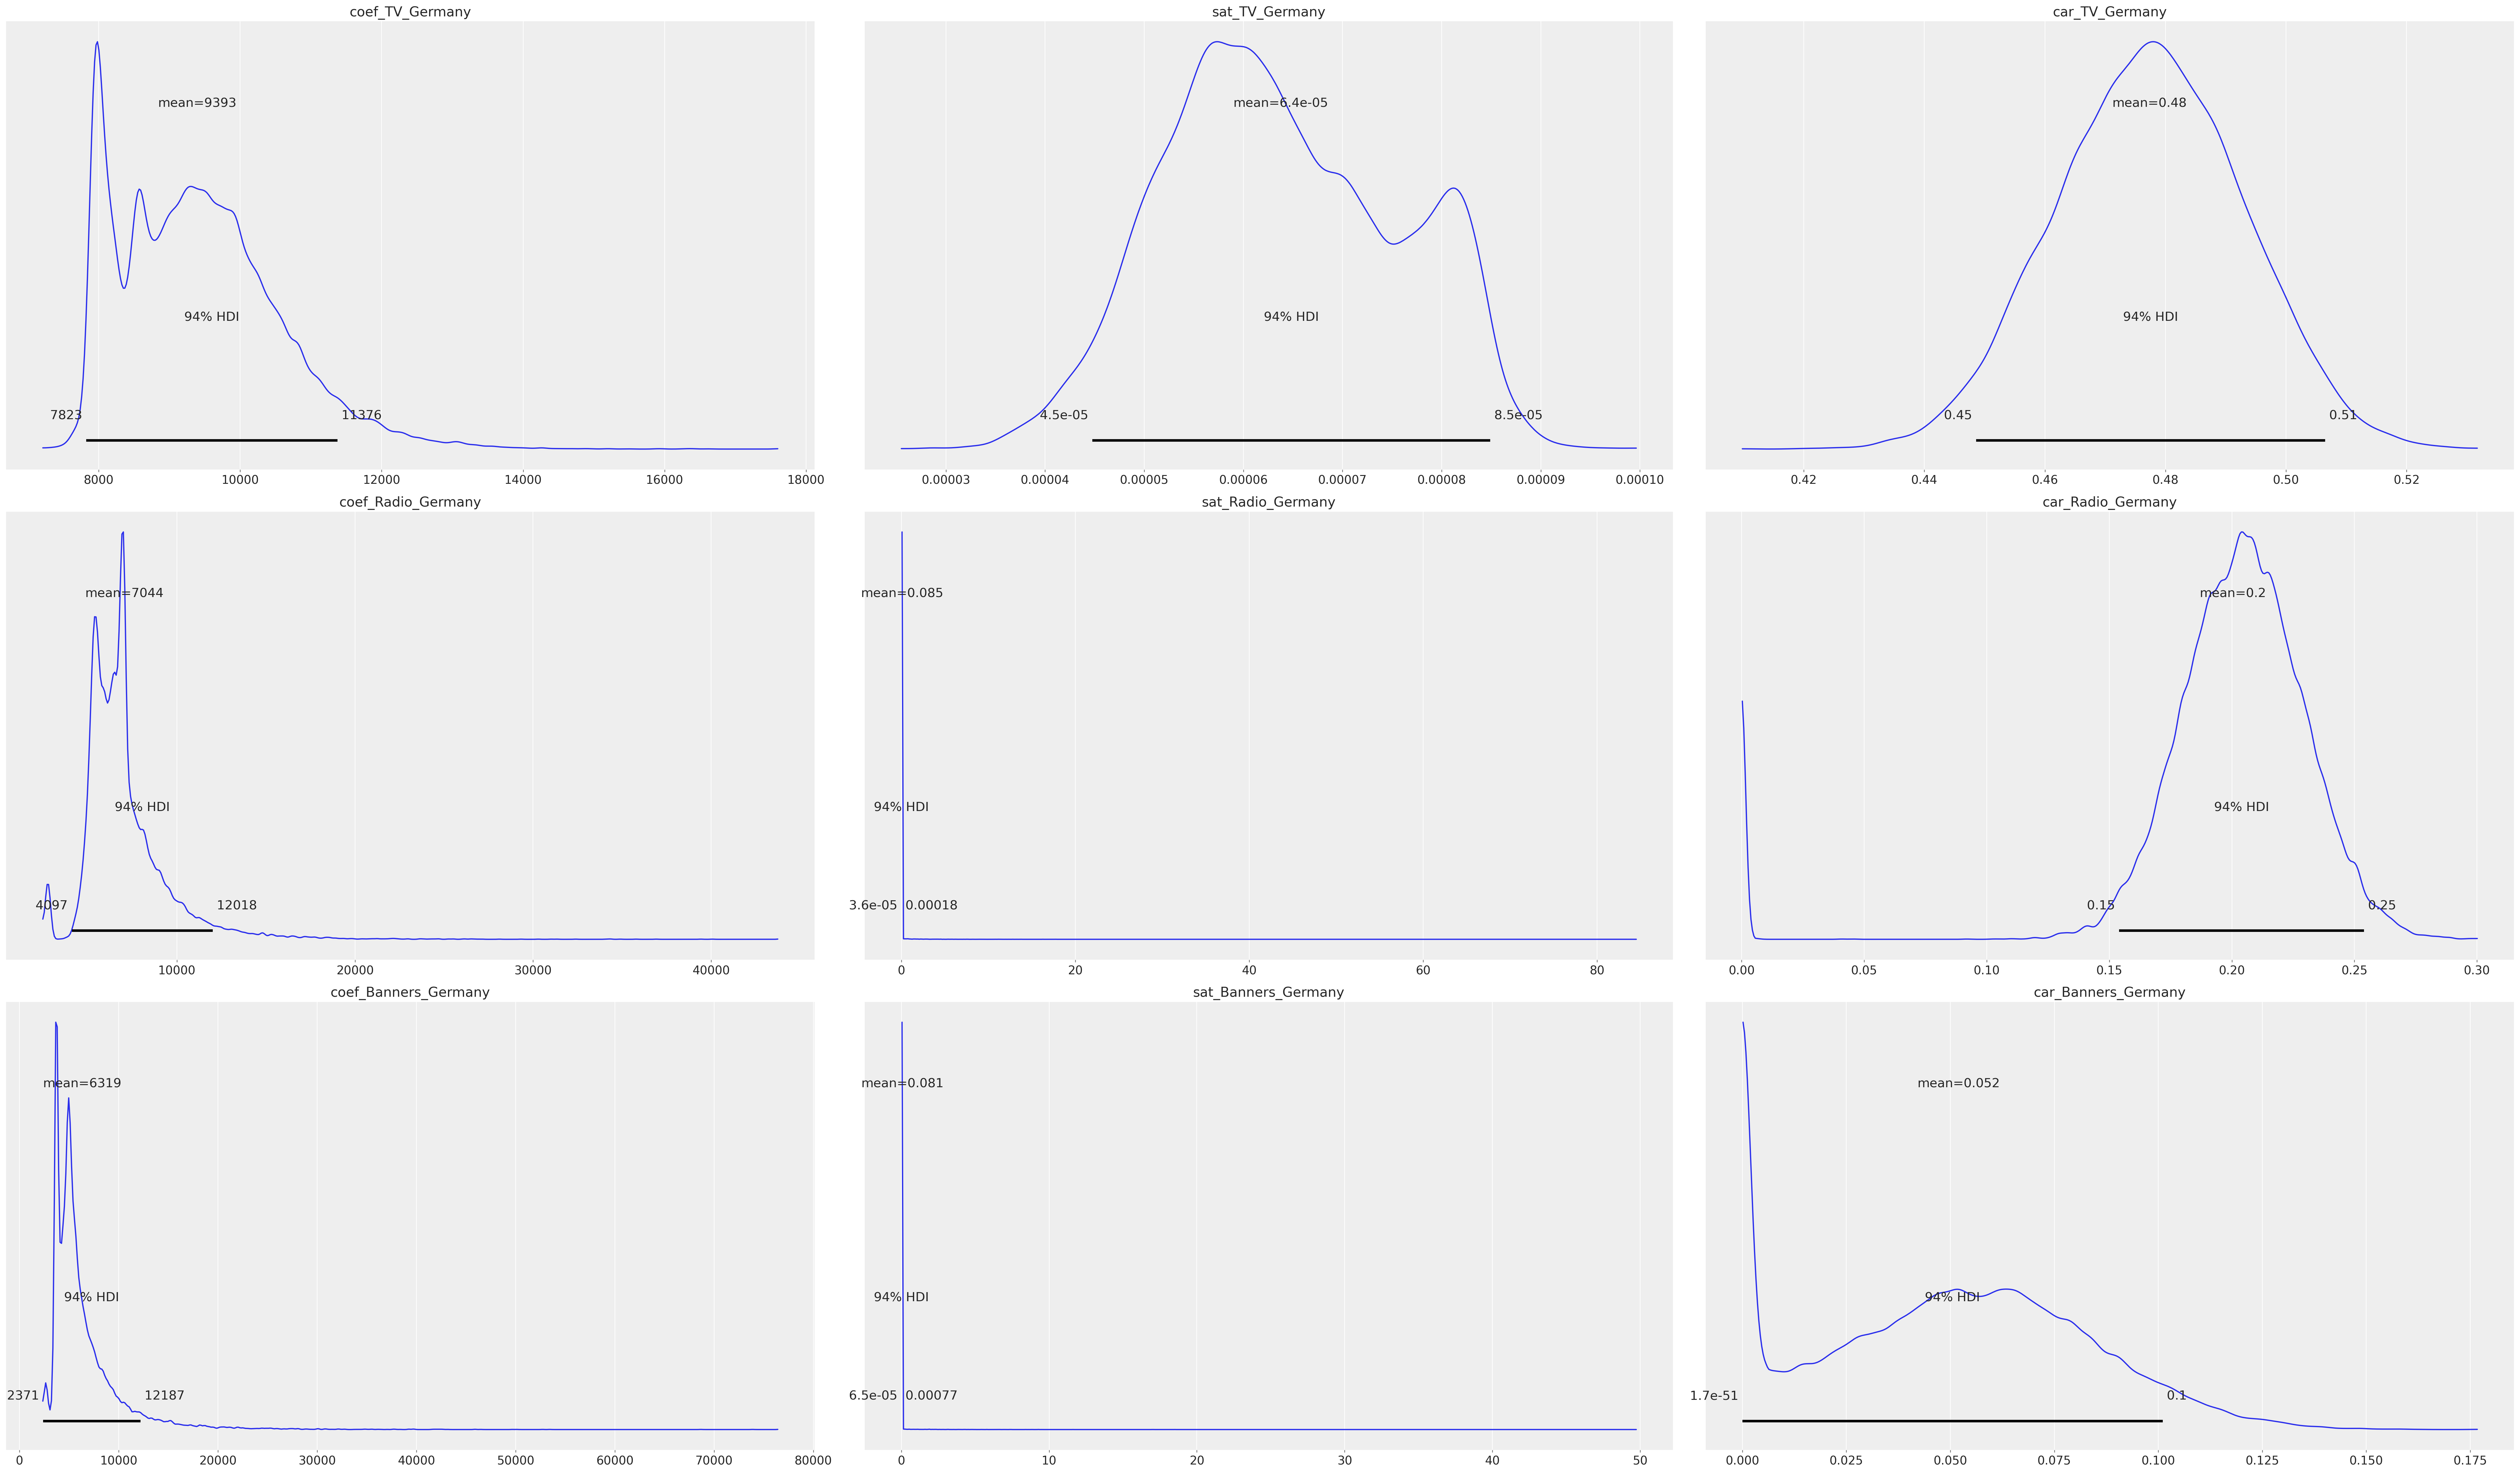

In [26]:
az.plot_posterior(
    trace,
    var_names=["coef_TV_Germany", "sat_TV_Germany", "car_TV_Germany", "coef_Radio_Germany", "sat_Radio_Germany", "car_Radio_Germany", "coef_Banners_Germany", "sat_Banners_Germany", "car_Banners_Germany"],
    filter_vars='like'
)

array([[<Axes: title={'center': 'coef_TV_Austria'}>,
        <Axes: title={'center': 'sat_TV_Austria'}>,
        <Axes: title={'center': 'car_TV_Austria'}>],
       [<Axes: title={'center': 'coef_Radio_Austria'}>,
        <Axes: title={'center': 'sat_Radio_Austria'}>,
        <Axes: title={'center': 'car_Radio_Austria'}>],
       [<Axes: title={'center': 'coef_Banners_Austria'}>,
        <Axes: title={'center': 'sat_Banners_Austria'}>,
        <Axes: title={'center': 'car_Banners_Austria'}>]], dtype=object)

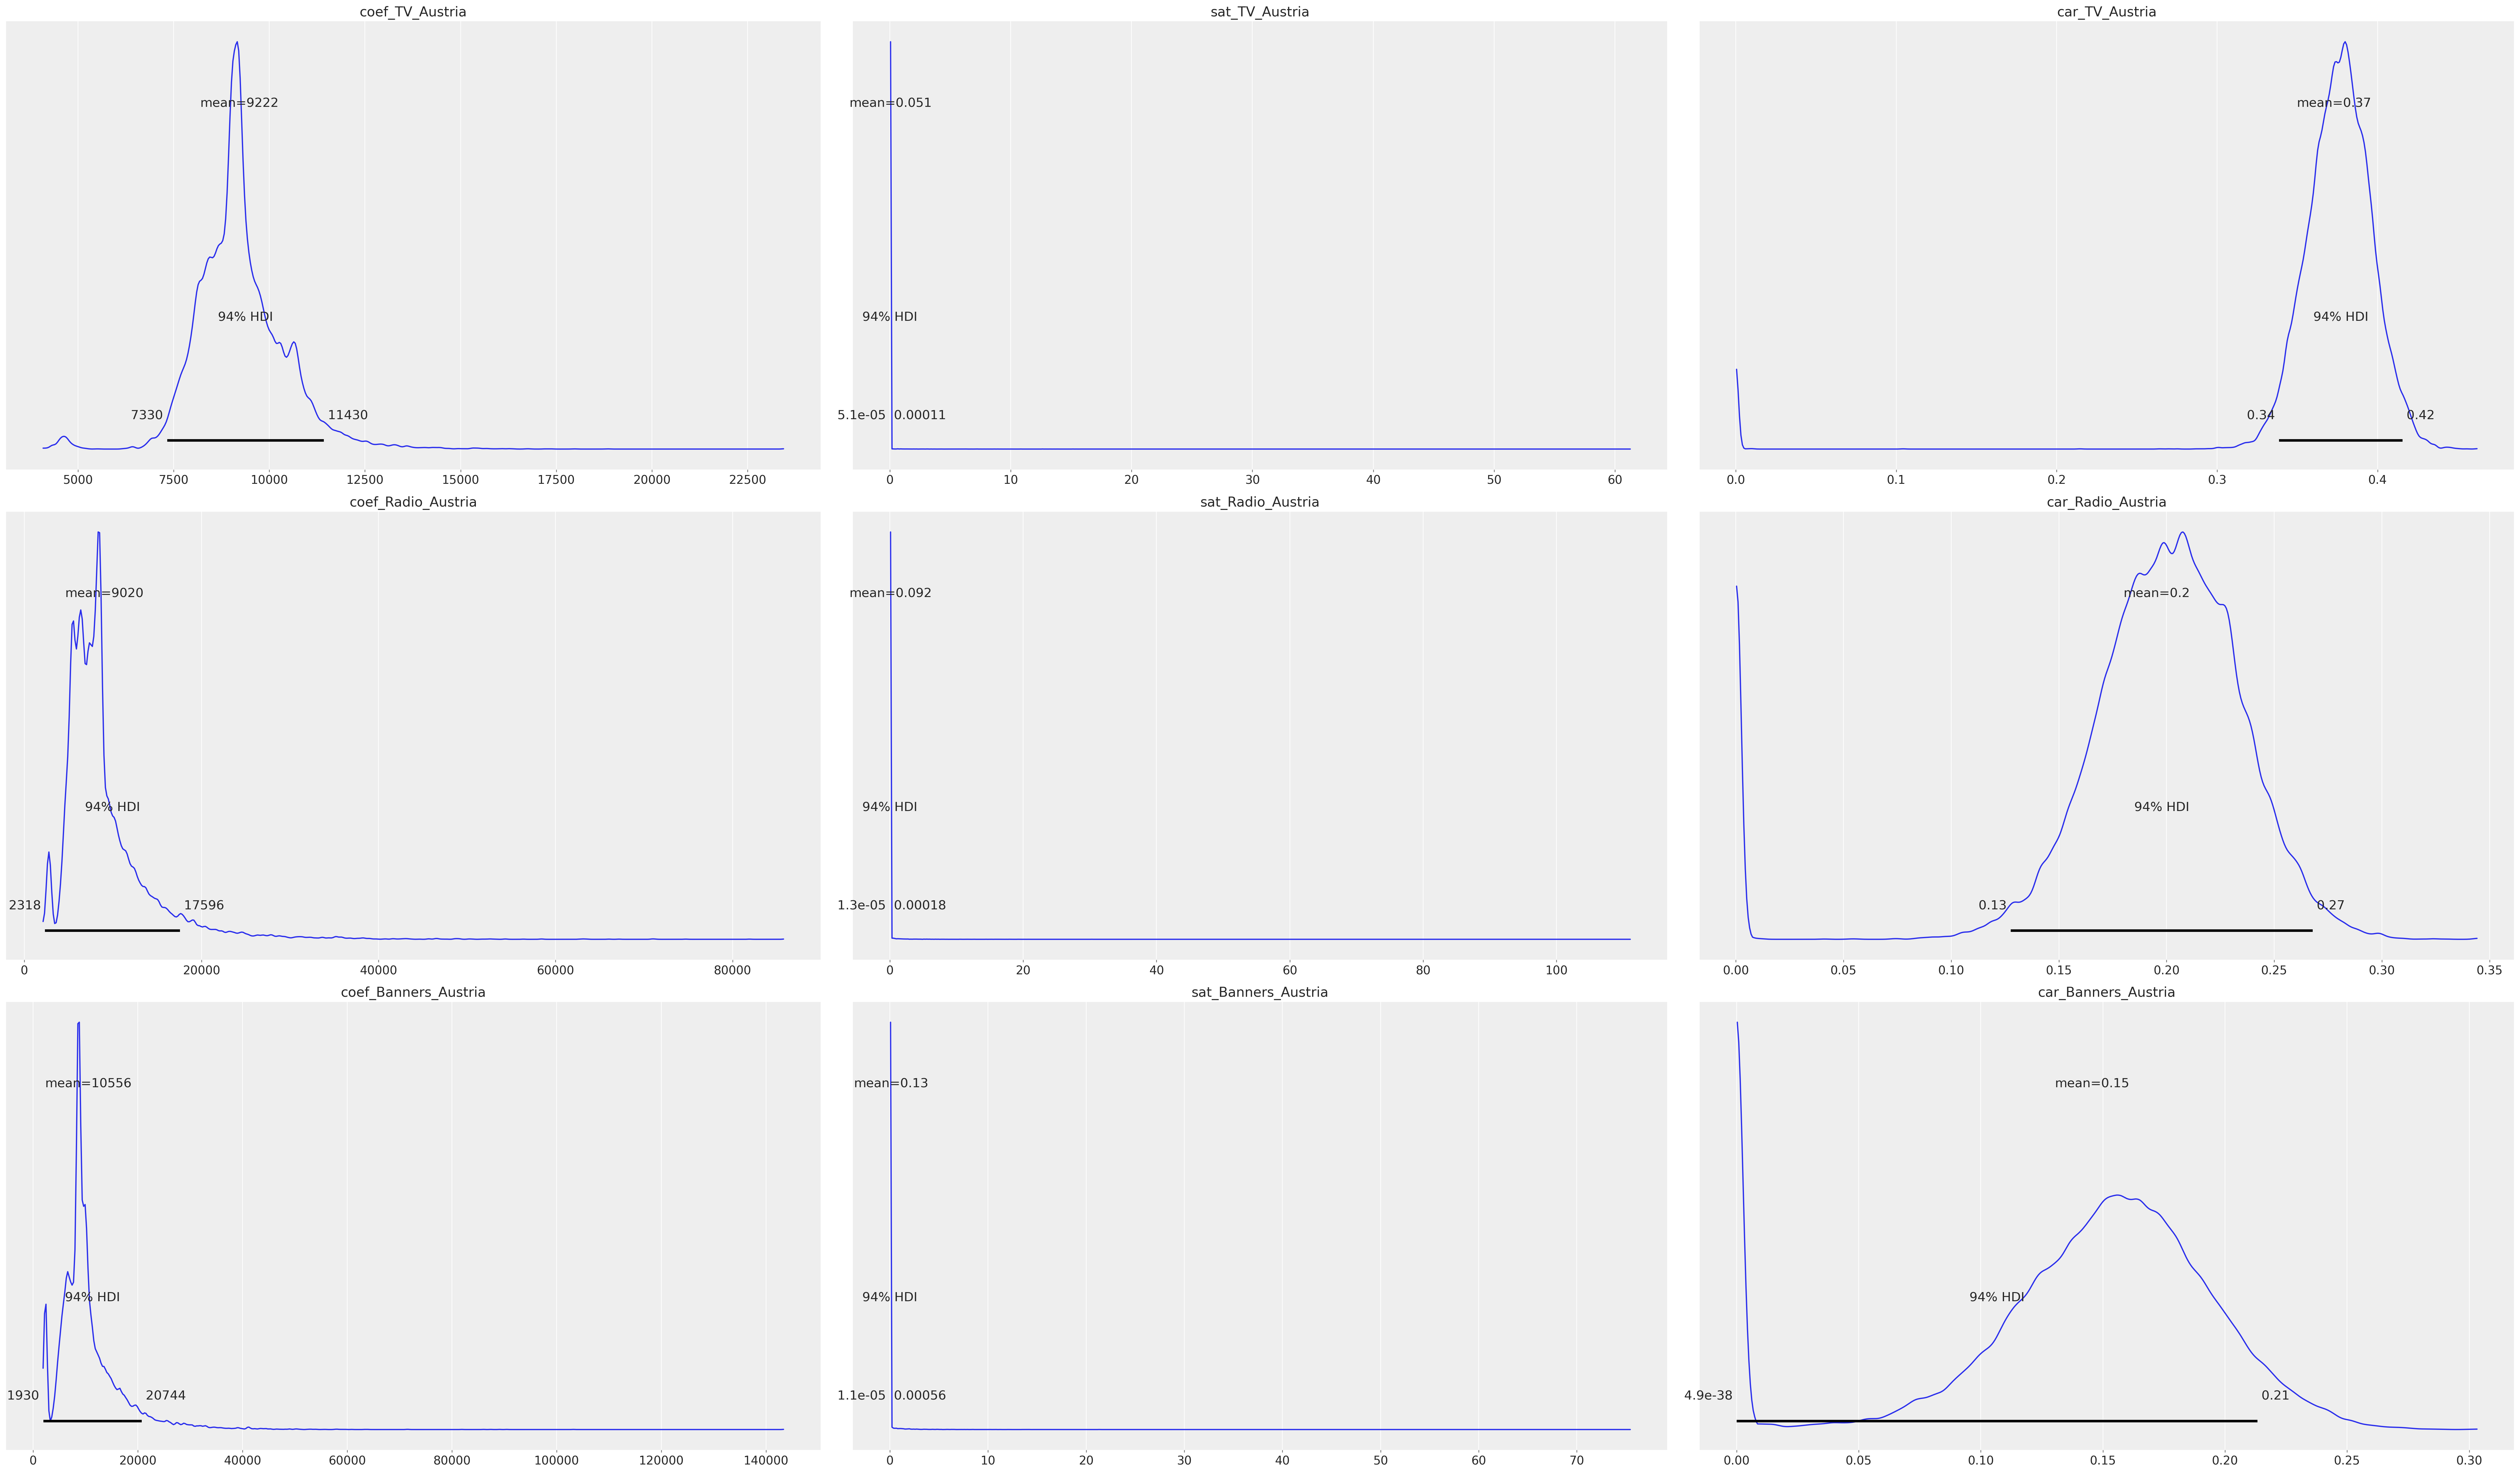

In [27]:
az.plot_posterior(
    trace,
    var_names=["coef_TV_Austria", "sat_TV_Austria", "car_TV_Austria", "coef_Radio_Austria", "sat_Radio_Austria", "car_Radio_Austria", "coef_Banners_Austria", "sat_Banners_Austria", "car_Banners_Austria"],
    filter_vars='like'
)

array([[<Axes: title={'center': 'coef_TV_Switzerland'}>,
        <Axes: title={'center': 'sat_TV_Switzerland'}>,
        <Axes: title={'center': 'car_TV_Switzerland'}>],
       [<Axes: title={'center': 'coef_Radio_Switzerland'}>,
        <Axes: title={'center': 'sat_Radio_Switzerland'}>,
        <Axes: title={'center': 'car_Radio_Switzerland'}>],
       [<Axes: title={'center': 'coef_Banners_Switzerland'}>,
        <Axes: title={'center': 'sat_Banners_Switzerland'}>,
        <Axes: title={'center': 'car_Banners_Switzerland'}>]],
      dtype=object)

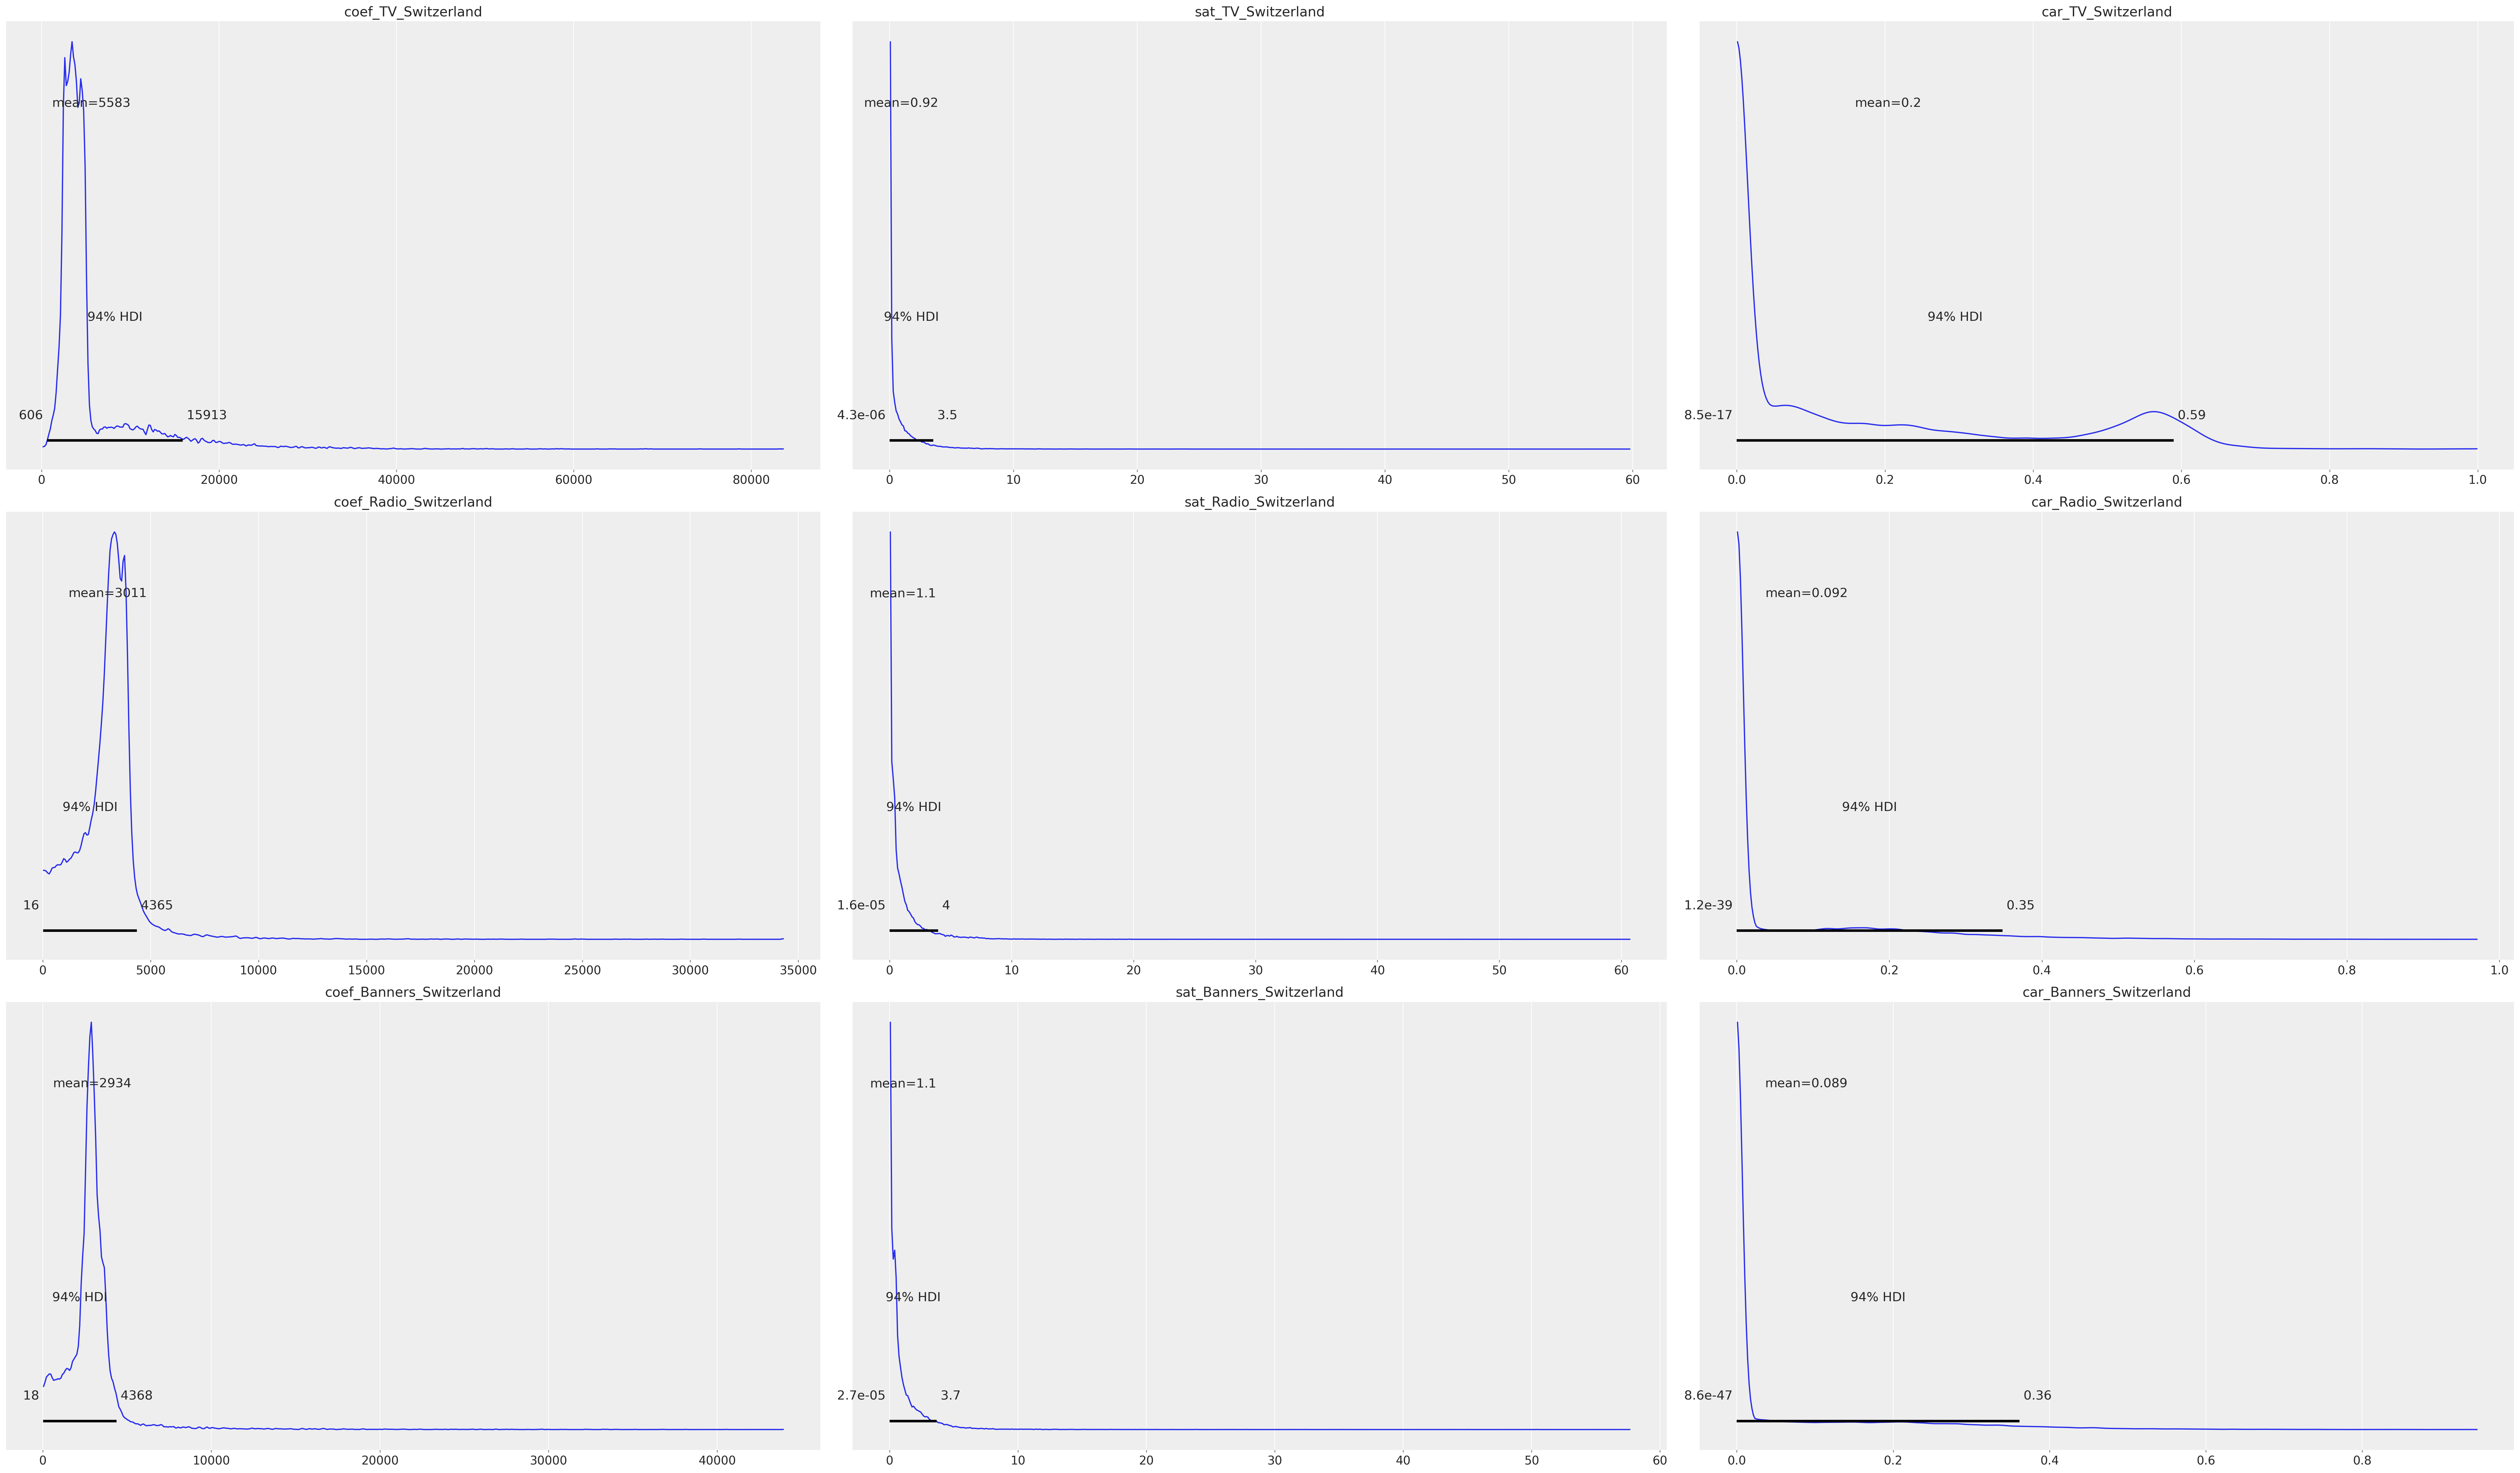

In [28]:
az.plot_posterior(
    trace,
    var_names=["coef_TV_Switzerland", "sat_TV_Switzerland", "car_TV_Switzerland", "coef_Radio_Switzerland", "sat_Radio_Switzerland", "car_Radio_Switzerland", "coef_Banners_Switzerland", "sat_Banners_Switzerland", "car_Banners_Switzerland"],
    filter_vars='like'
)

The posteriors for each parameter are displayed here. Each of them has a lovely unimodal (=one peak) form. We should also check if the model is any good before we jump to conclusions.

There are still some somewhat erratic distributions, and we would need to investigate further to find a solution. Among other things, there may be problems with the sampling or flawed priors. But we're not going to do that here.


In [29]:
with bhmmm:
    
    bhmmm_posterior_predictive = pm.sample_posterior_predictive(
        trace=trace
    )

posterior_predictive_likelihood_germany = az.extract(
    data=bhmmm_posterior_predictive,
    group="posterior_predictive",
    var_names="sales_Germany",
)


posterior_predictive_likelihood_Austria = az.extract(
    data=bhmmm_posterior_predictive,
    group="posterior_predictive",
    var_names="sales_Austria",
)

posterior_predictive_likelihood_Switzerland = az.extract(
    data=bhmmm_posterior_predictive,
    group="posterior_predictive",
    var_names="sales_Switzerland",
)



Sampling: [sales_Austria, sales_Germany, sales_Switzerland]


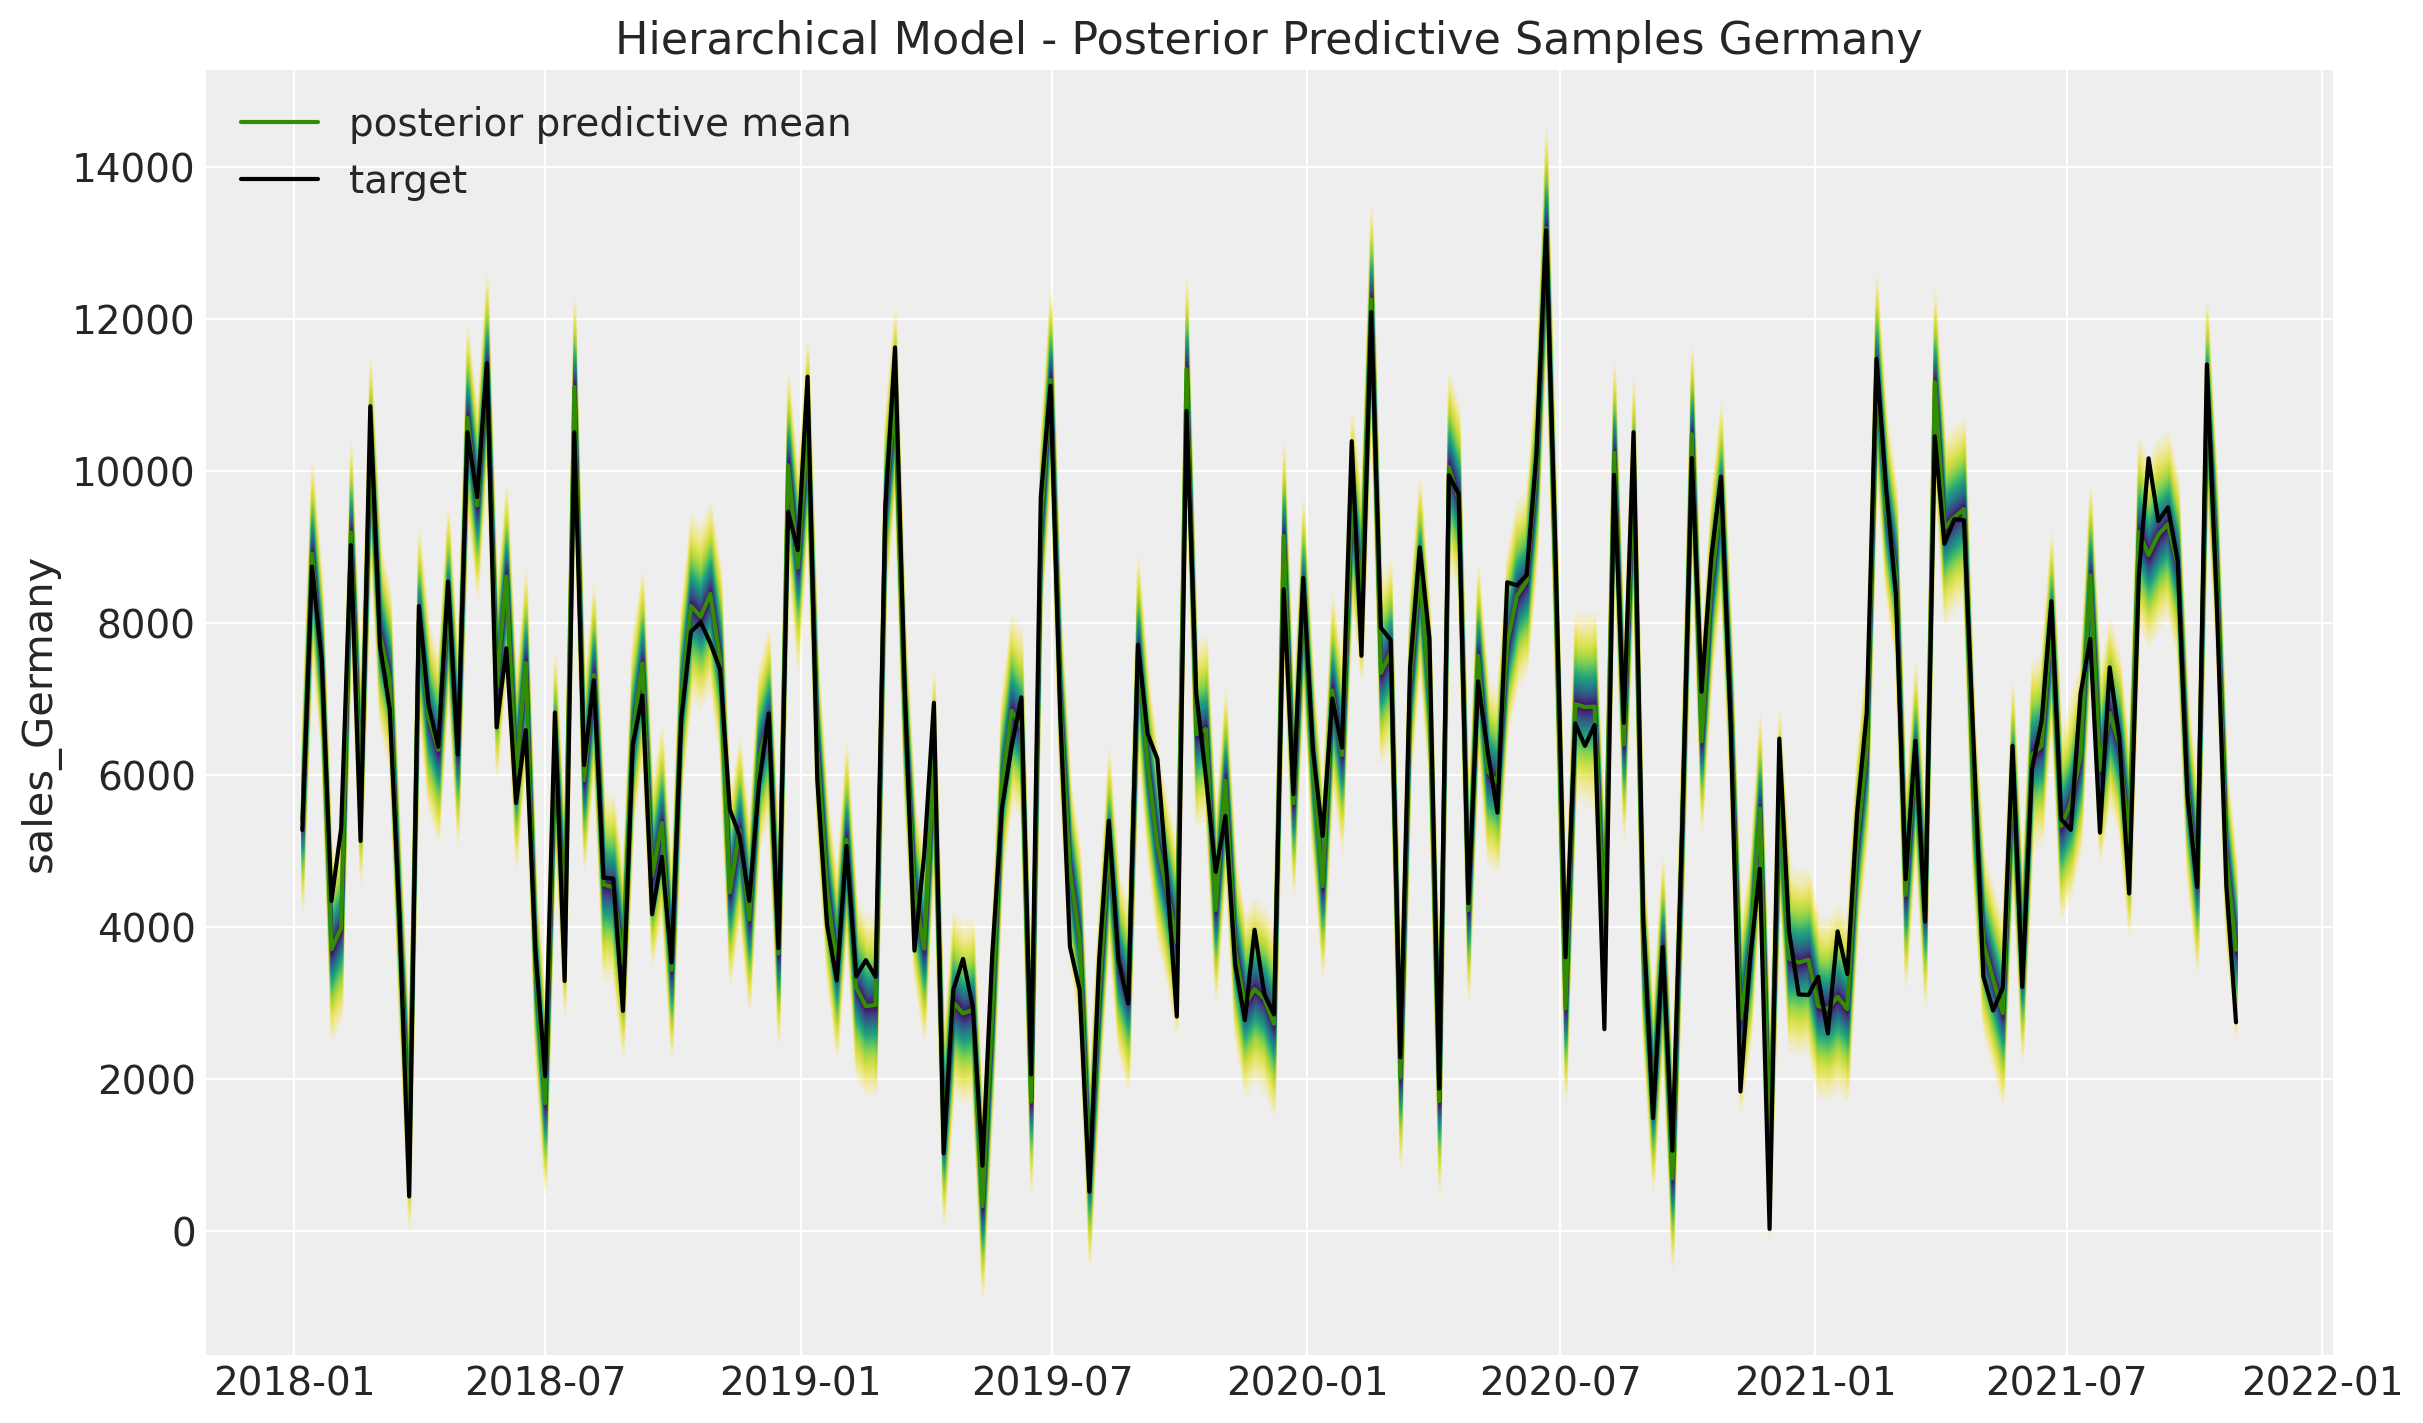

In [31]:
# useful way to color the distribution
palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


means_ger = posterior_predictive_likelihood_germany.mean(axis=1)
stds_ger = posterior_predictive_likelihood_germany.std(axis=1)

means_aus = posterior_predictive_likelihood_Austria.mean(axis=1)
stds_aus = posterior_predictive_likelihood_Austria.std(axis=1)

means_swi = posterior_predictive_likelihood_Switzerland.mean(axis=1)
stds_swi = posterior_predictive_likelihood_Switzerland.std(axis=1)


fig, ax = plt.subplots()

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_likelihood_germany, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood_germany, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=data_df['Date'].unique().to_numpy(),
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x=data_df['Date'].unique().to_numpy(),
    y=posterior_predictive_likelihood_germany.mean(axis=1),
    color="C2",
    label="posterior predictive mean",
    ax=ax,
)
sns.lineplot(
    x=data_df['Date'].unique().to_numpy(),
    y=data_df[data_df['Country']=='Germany']['Sales'].to_numpy(),
    color="black",
    label="target",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Hierarchical Model - Posterior Predictive Samples Germany");

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


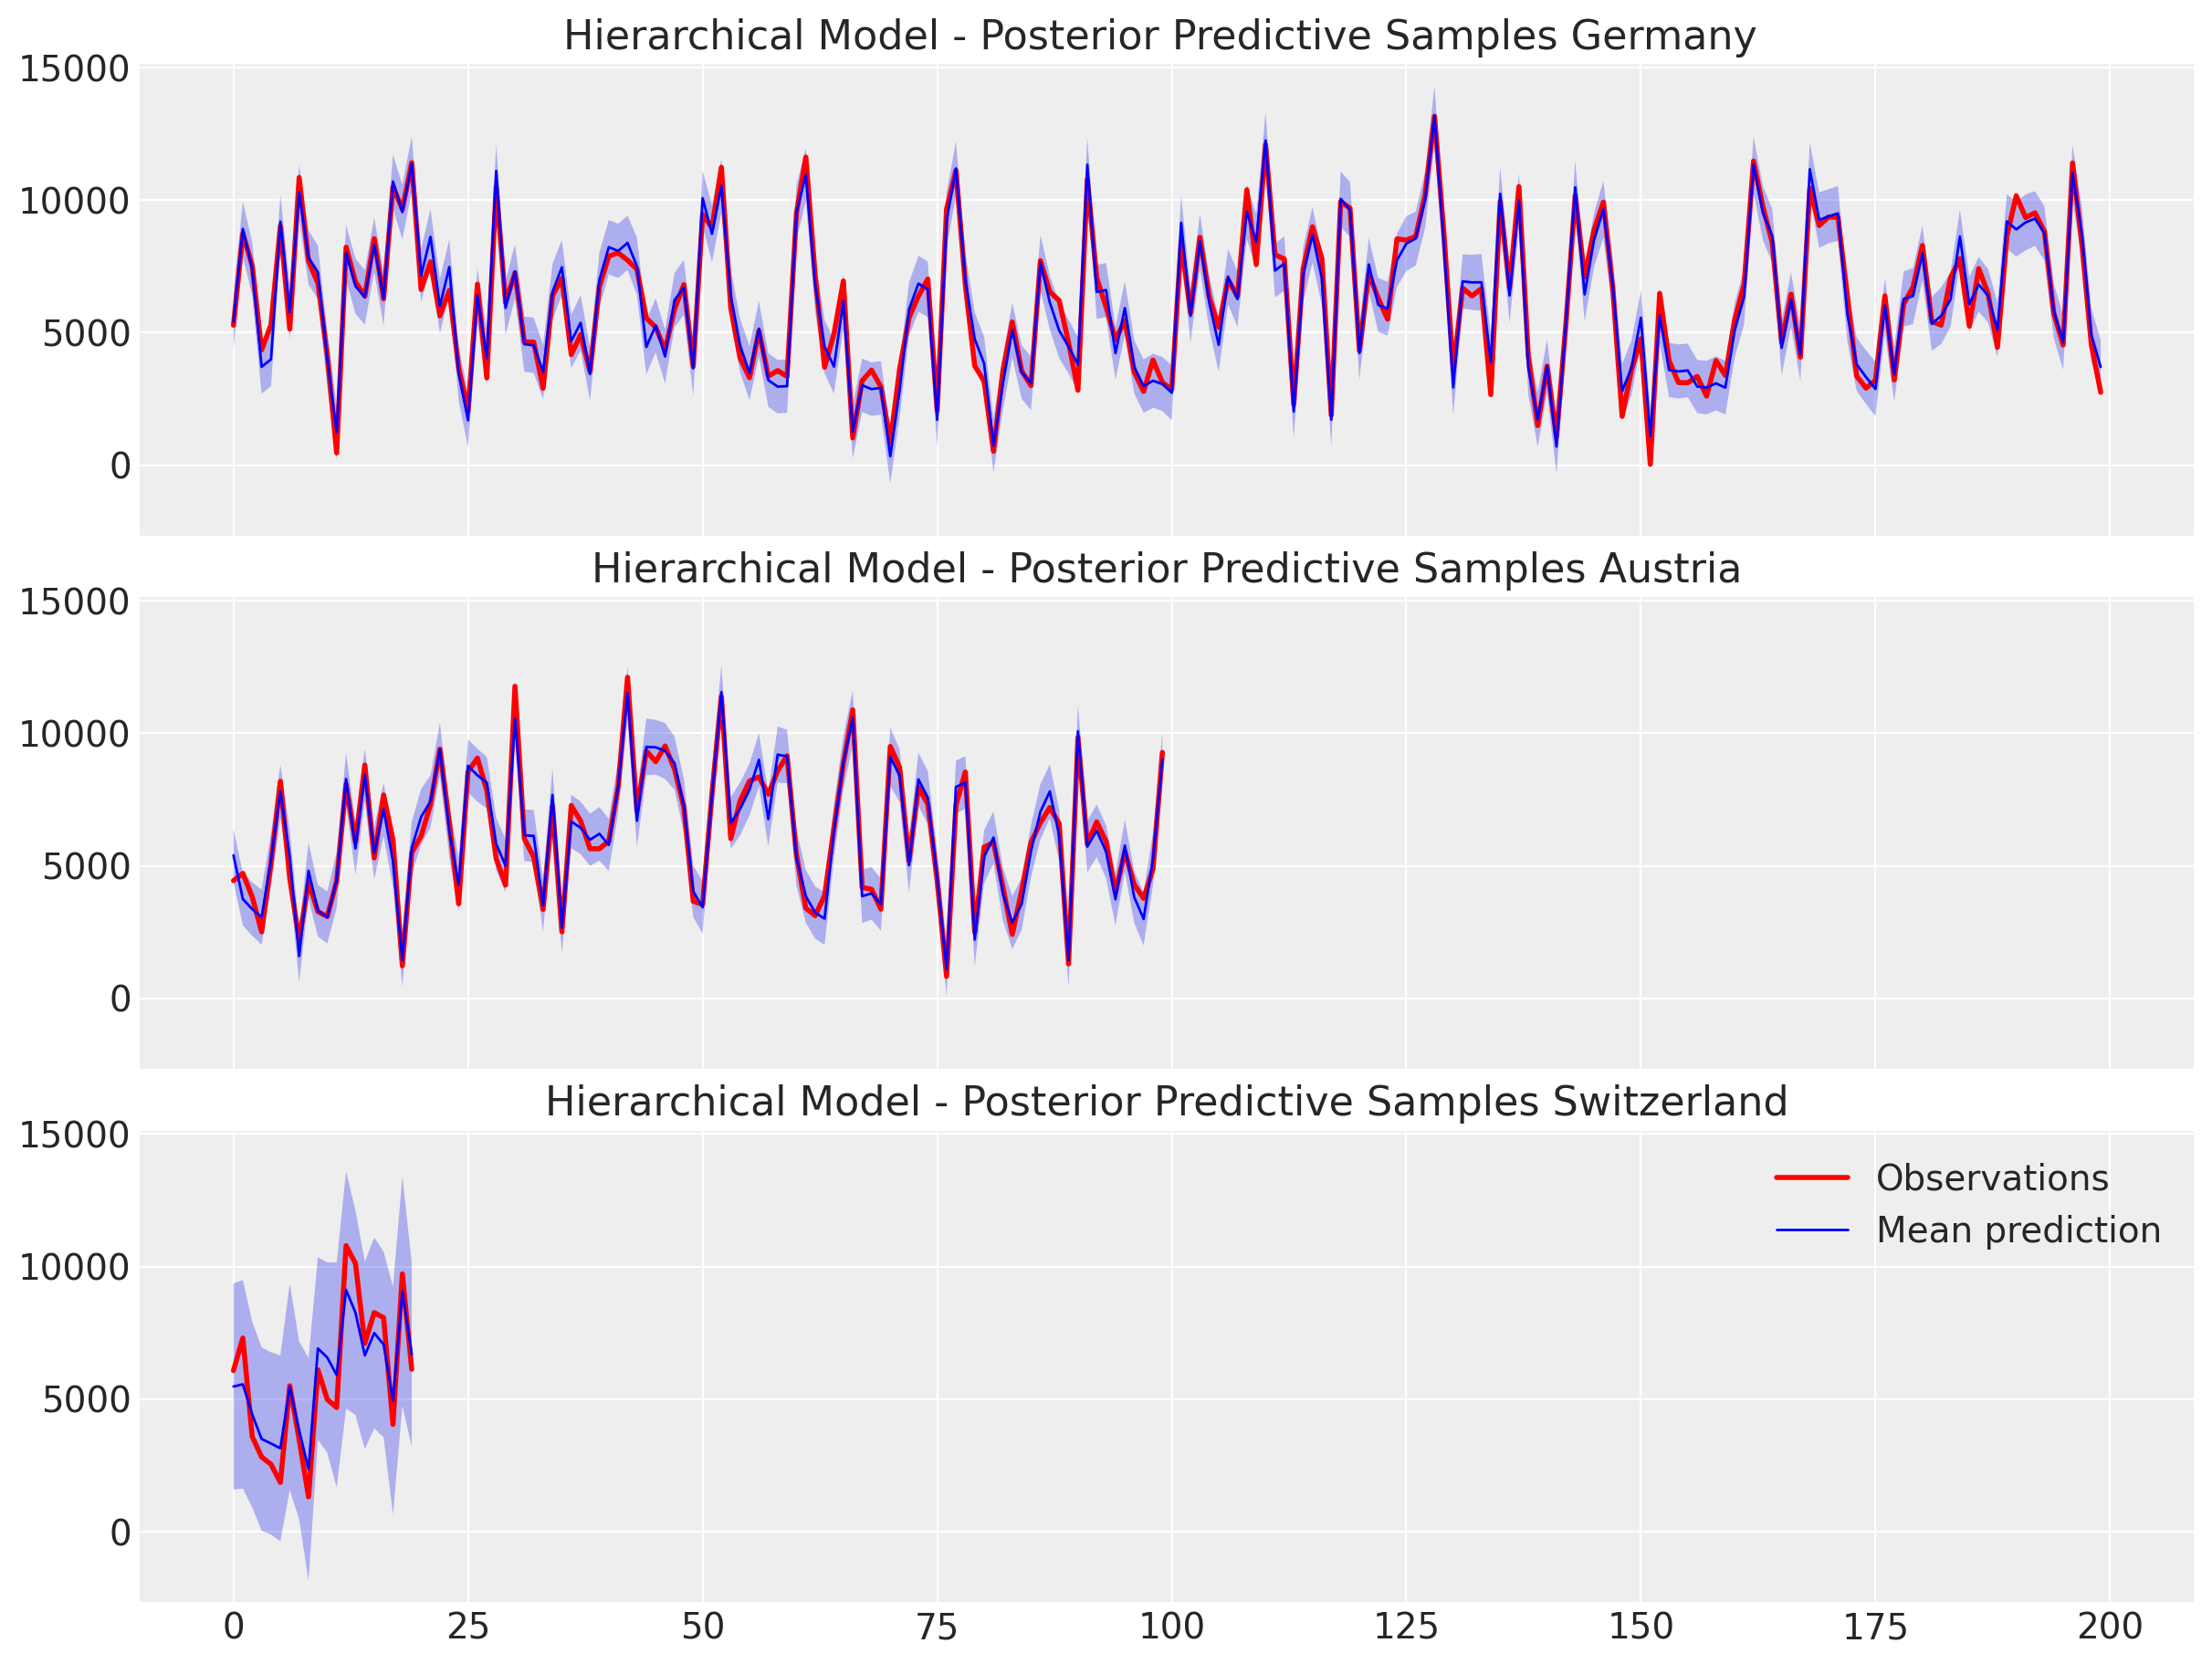

In [39]:
fig, ax = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(12,9),
    sharex=True,
    sharey=True,
    layout='constrained'
)


ax[0].plot(data_df[data_df['Country']=='Germany']['Sales'].to_numpy(), linewidth=2, c='r', label='Observations')
ax[0].plot(means_ger, linewidth=1, c='b', label='Mean prediction')
ax[0].fill_between(np.arange(len(data_df[data_df['Country']=='Germany']['Sales'].to_numpy())), means_ger - 2*stds_ger, means_ger + 2*stds_ger, alpha=0.33)
ax[0].set(title="Hierarchical Model - Posterior Predictive Samples Germany ")


ax[1].plot(data_df[data_df['Country']=='Austria']['Sales'].to_numpy(), linewidth=2, c='r', label='Observations')
ax[1].plot(means_aus, linewidth=1, c='b', label='Mean prediction')
ax[1].fill_between(np.arange(len(data_df[data_df['Country']=='Austria']['Sales'].to_numpy())), means_aus - 2*stds_aus, means_aus + 2*stds_aus, alpha=0.33)
ax[1].set(title="Hierarchical Model - Posterior Predictive Samples Austria")



ax[2].plot(data_df[data_df['Country']=='Switzerland']['Sales'].to_numpy(), linewidth=2, c='r', label='Observations')
ax[2].plot(means_swi, linewidth=1, c='b', label='Mean prediction'), 
ax[2].fill_between(np.arange(len(data_df[data_df['Country']=='Switzerland']['Sales'].to_numpy())), means_swi - 2*stds_swi, means_swi + 2*stds_swi, alpha=0.33)
ax[2].set(title="Hierarchical Model - Posterior Predictive Samples Switzerland")
plt.legend()


By using the Hierarchical model, we can conclude that even in certain nations with very few data points, the model fits rather well; this is because the information from similar countries is shared by the Hierarchical model. Geographically speaking, we might argue that all three nations are similar. 

In [41]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [50]:
trace.posterior[f'contribution_TV_Germany'].values

array([[[5506.56252586, 3358.88740589, 1824.64172108, ...,
         3228.52809434, 1743.69095673,  887.30339605],
        [5419.31844275, 3246.71899942, 1743.55020409, ...,
         3115.55391783, 1663.91623956,  840.70949378],
        [5357.50790644, 3191.66741093, 1792.32091927, ...,
         3166.68662522, 1777.19514807,  965.48614045],
        ...,
        [5384.62992495, 3175.79820518, 1635.88796699, ...,
         3002.07337381, 1533.22252342,  733.91471873],
        [5384.62992495, 3175.79820518, 1635.88796699, ...,
         3002.07337381, 1533.22252342,  733.91471873],
        [5384.62992495, 3175.79820518, 1635.88796699, ...,
         3002.07337381, 1533.22252342,  733.91471873]],

       [[5207.35199307, 2991.21622862, 1587.6636578 , ...,
         2882.77095893, 1524.90970244,  775.15797615],
        [5422.0544495 , 3056.37153094, 1601.87411844, ...,
         2938.48837617, 1535.12980419,  773.51356172],
        [5352.10244487, 3105.42149379, 1652.97453292, ...,
         2989.

In [48]:
def compute_mean(trace, channel):
    return (trace
            .posterior[f'contribution_{channel}_Germany']
            .values
            .reshape(1, -1)
            .mean(0)
           )

channels = ['Banners', 'Radio', 'TV']


unadj_contributions = pd.DataFrame(
    {'Base_Germany': trace.posterior['base_Germany'].values.mean()},
    index=X.index
)

for channel in channels:
    unadj_contributions[channel] = compute_mean(trace, channel)

adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(data_df[data_df['Country']=='Germany']['Sales'].to_numpy(), axis=0)
                    )

ax = (adj_contributions
      .plot.area(
          figsize=(16, 10),
          linewidth=1,
          title='Predicted Sales for Germany and Breakdown',
          ylabel='Sales',
          xlabel='Date'
      )
     )
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)

ValueError: Length of values (4800000) does not match length of index (320)